In [ ]:
!pip install --upgrade pip
!pip install "tensorflow[and-cuda]"
!pip install pandas
 

In [1]:
# Importa o tensorflow e verifica se a GPU está disponível
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2024-07-29 22:12:07.918196: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 22:12:08.007372: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 22:12:08.033657: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-29 22:12:08.212339: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-29 22:12:09.205798: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1722305530.292413   27462 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722305530.458952   27462 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722305530.459112   27462 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [2]:
# Configurações
BATCH_SIZE = 32
EPOCHS = 100
IMAGE_SIZE = 64

In [3]:
import string 

# Função para remover números de uma string
def remove_numbers(s):
    return s.translate(str.maketrans('', '', string.digits))

In [4]:
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os 
from PIL import Image
import string


# Sao 31 imagens diferentes onde cada uma representa um canal de cor
def load_multispectral_imagem(image_dir):
    # Pega o diretorio de uma amostra
    file_names = sorted(os.listdir(image_dir))
    # Quantidade de graos é a quantidade de imagens dividido por 31
    qtd_graos = int(len(file_names)/31)
    print(f'Quantidade de graos: {qtd_graos}')

    multispectral_imgs = []

    # Para cada grao carrega as 31 imagens e empilha elas em um array
    for i in range(qtd_graos):
        images = [np.array(Image.open(os.path.join(image_dir, file))) for file in file_names[i*31:(i+1)*31]]
        multispectral_img = np.stack(images, axis=-1)   
        multispectral_imgs.append(multispectral_img)    

    return multispectral_imgs

In [5]:
# Função para carregar as imagens
def process_path(image_dir, label):
    # Carrega as imagens
    images = load_multispectral_imagem(image_dir)
    # Cria um array de labels
    labels = [label]*len(images)
    # Retorna as imagens e os labels em um dataset do tensorflow
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    
    # Converte as imagens para uint8 e os labels para int32
    # uint8 é um tipo de dado que armazena inteiros de 0 a 255
    # int32 é um tipo de dado que armazena inteiros de -2^31 a 2^31-1
    dataset = dataset.map(lambda x, y: (tf.cast(x, tf.uint8), tf.cast(y, tf.int32)))

    # Separa o dataset em batches
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [6]:
folder_to_label = {}
id_to_label = {}

# Carrega as pastas
folders = sorted(os.listdir('_recortado'))

i = -1
for folder in folders:
    # Pega as pastas das amostras remove o numero e temos um cateogria
    keys = list(map(lambda x: remove_numbers(x), folder_to_label.keys()))
    if not remove_numbers(folder) in keys:
        i += 1
        folder_to_label[folder] = i
    else:
        folder_to_label[folder] = i

for key, value in folder_to_label.items():
    id_to_label[value] = remove_numbers(key)

# No total sao 5 categorias e criamos dois objetos 
# Um que sai do id para o label e outro que sai do label para o id

print(folder_to_label)
print(id_to_label)
    
 

{'bandinhas1': 0, 'bandinhas2': 0, 'bandinhas3': 0, 'bandinhas4': 0, 'bandinhas5': 0, 'fermentados1': 1, 'fermentados2': 1, 'fermentados3': 1, 'fermentados4': 1, 'fermentados5': 1, 'mofados1': 2, 'mofados2': 2, 'mofados3': 2, 'mofados4': 2, 'mofados5': 2, 'queimados1': 3, 'queimados2': 3, 'queimados3': 3, 'queimados4': 3, 'queimados5': 3, 'soja1': 4, 'soja2': 4, 'soja3': 4, 'soja4': 4, 'soja5': 4}
{0: 'bandinhas', 1: 'fermentados', 2: 'mofados', 3: 'queimados', 4: 'soja'}


In [8]:
# Função para criar o dataset
def create_dataset(base_dir, folder_to_label):
    all_datasets = []

    # Para cada pasta, carrega as imagens e os labels 
    # Adiciona o dataset na lista de datasets
    for folder_name, label in folder_to_label.items():
        class_dir = os.path.join(base_dir, folder_name)
        dataset = process_path(class_dir, label)
        all_datasets.append(dataset)
    
    # Mescla todos os datasets em um único dataset
    dataset = all_datasets[0]
    for ds in all_datasets[1:]:
        dataset = dataset.concatenate(ds)

    return dataset

# Chama a função para criar o dataset
dataset = create_dataset('_recortado', folder_to_label=folder_to_label)

Quantidade de graos: 158
Quantidade de graos: 145
Quantidade de graos: 160
Quantidade de graos: 160
Quantidade de graos: 217
Quantidade de graos: 92
Quantidade de graos: 112
Quantidade de graos: 115
Quantidade de graos: 142
Quantidade de graos: 113
Quantidade de graos: 56
Quantidade de graos: 55
Quantidade de graos: 56
Quantidade de graos: 53
Quantidade de graos: 54
Quantidade de graos: 130
Quantidade de graos: 121
Quantidade de graos: 127
Quantidade de graos: 123
Quantidade de graos: 117
Quantidade de graos: 265
Quantidade de graos: 143
Quantidade de graos: 120
Quantidade de graos: 191
Quantidade de graos: 111


In [9]:
len(dataset)


106

In [10]:
# funcao que mostra todos batch de imagens do dataset
def preview_dataset(dataset):    
    batch_count = 0
    for images_batch, labels_batch in dataset:
        print(f'Batch de imagens shape: {images_batch.shape}')
        print(f'Batch de labels shape: {labels_batch.shape}')
        
        for image, label in zip(images_batch, labels_batch):
            qtd_canais = image.shape[-1]

            print(image.shape)    
            print(id_to_label[label.numpy() ])

            plt.figure(figsize=(64,64))
            for i in range(qtd_canais):
                image_to_show = image[..., i]
                plt.subplot(1,31,i+1)
                plt.imshow(image_to_show)
                plt.axis('off')
            plt.show()

#preview_dataset(dataset)

In [11]:
# Funcao para separar o dataset em treino, validacao e teste e embaralhar
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    total_size = len(ds)
    train_size = int(total_size * train_split)
    validation_size = int(total_size * val_split)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_ds = ds.take(train_size)
    remaining_ds = ds.skip(train_size)

    val_ds = remaining_ds.take(validation_size)
    test_ds = remaining_ds.skip(validation_size)
    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

print(f'Quantidade de imagens de treino: {len(train_ds)}')
print(f'Quantidade de imagens de validação: {len(val_ds)}')
print(f'Quantidade de imagens de teste: {len(test_ds)}')

# Cache: Mantém as imagens na memória após serem carregadas do disco
# Shuffle: Mistura as imagens de treino
# Prefetch: Carrega as imagens para a GPU enquanto a GPU está ocupada
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Quantidade de imagens de treino: 84
Quantidade de imagens de validação: 10
Quantidade de imagens de teste: 12


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 31), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [13]:
# altera o tamanho da imagem e normaliza os valores
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

# aumenta a quantidade de imagens no dataset atraves de flip e rotacao
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),   
    layers.RandomRotation(0.2),
])

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 31) 
n_classes = len(id_to_label)
print(n_classes)


5


In [14]:
# visualizacao dos tensores
for data, label in train_ds.take(10):
    print(data.shape, label)

(31, 64, 64, 31) tf.Tensor([3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3], shape=(31,), dtype=int32)
(32, 64, 64, 31) tf.Tensor([4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4], shape=(32,), dtype=int32)
(32, 64, 64, 31) tf.Tensor([3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3], shape=(32,), dtype=int32)
(32, 64, 64, 31) tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(32,), dtype=int32)
(32, 64, 64, 31) tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(32,), dtype=int32)
(32, 64, 64, 31) tf.Tensor([4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4], shape=(32,), dtype=int32)
(32, 64, 64, 31) tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(32,), dtype=int32)
(32, 64, 64, 31) tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(32,), dtype=int32)
(32, 64, 64, 31) tf.Tensor([4 4 4 4 4 4 4 

2024-07-29 22:13:31.333792: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 31)

# Cria o modelo de rede neural convolucional
# Aplicando camadas de convolução, pooling e densas
# Densas são camadas totalmente conectadas
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')  # Camada de saída com softmax para n classes
])


# Compila o modelo aplicando a função de otimização, função de perda e métricas
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Função de perda para classificação multiclasse
              metrics=['accuracy'])


# model.summary()

# Treina o modelo
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/100


/home/duardo/Projects/cellpose/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-07-29 22:13:34.334489: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
W0000 00:00:1722305614.543250   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305614.569074   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305614.571176   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305614.589231   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305614.590660   

 1/84 ━━━━━━━━━━━━━━━━━━━━ 4:12 3s/step - accuracy: 0.0000e+00 - loss: 1.5616

W0000 00:00:1722305615.325037   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305615.326582   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305615.328608   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305615.329580   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305615.330539   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305615.332582   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305615.335181   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305615.336167   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305615.337424   30580 gp

11/84 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.1731 - loss: 2.1027      

W0000 00:00:1722305615.728960   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305615.729847   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305615.730716   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305615.732034   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305615.733406   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305615.734975   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305615.735838   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305615.736739   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305615.738186   30584 gp

17/84 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.2292 - loss: 2.0320

W0000 00:00:1722305616.154656   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305616.155775   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305616.156751   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305616.158603   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305616.159578   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305616.160535   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305616.161597   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305616.162518   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305616.164061   30583 gp

19/84 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.2351 - loss: 2.0114

W0000 00:00:1722305616.560390   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305616.562927   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305616.566208   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305616.569220   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305616.571684   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305616.573792   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305616.577672   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305616.580259   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305616.583907   30579 gp

20/84 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.2373 - loss: 2.0030

W0000 00:00:1722305616.763029   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305616.764492   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305616.765249   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305616.766015   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305616.766753   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305616.774508   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305616.775615   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305616.776810   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305616.777524   30583 gp

24/84 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.2387 - loss: 1.9720

W0000 00:00:1722305617.166311   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305617.167883   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305617.169582   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305617.171450   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305617.172758   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305617.175039   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305617.177299   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305617.178663   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305617.180297   30584 gp

26/84 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.2383 - loss: 1.9577

W0000 00:00:1722305617.570761   30582 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305617.572078   30582 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305617.574626   30582 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305617.578351   30582 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305617.580013   30582 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305617.581688   30582 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305617.584234   30582 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305617.621997   30582 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305617.623036   30582 gp

30/84 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.2347 - loss: 1.9327

W0000 00:00:1722305617.771835   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305617.772874   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305617.774599   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305617.776627   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305617.777769   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305617.778813   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305617.780571   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305617.782653   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305617.783828   30584 gp

38/84 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.2314 - loss: 1.8926

W0000 00:00:1722305618.073710   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305618.074800   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305618.075823   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305618.077892   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305618.080392   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305618.081752   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305618.083536   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305618.085921   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305618.087540   30583 gp

45/84 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.2367 - loss: 1.8636

W0000 00:00:1722305618.278160   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305618.279862   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305618.280775   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305618.281767   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305618.282910   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305618.283805   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305618.285657   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305618.286572   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305618.287509   30584 gp

55/84 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.2400 - loss: 1.8326

W0000 00:00:1722305618.682630   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305618.683696   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305618.685538   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305618.686666   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305618.687888   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305618.689206   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305618.690834   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305618.692675   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305618.693910   30579 gp

57/84 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.2410 - loss: 1.8277

W0000 00:00:1722305619.086499   30581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305619.087844   30581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305619.089479   30581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305619.092309   30581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305619.093728   30581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305619.095585   30581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305619.098132   30581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305619.099547   30581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305619.100908   30581 gp

73/84 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2453 - loss: 1.7951

W0000 00:00:1722305619.489449   30582 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305619.491438   30582 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305619.493953   30582 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305619.495830   30582 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305619.498921   30582 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305619.501118   30582 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305619.502347   30582 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305619.505626   30582 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305619.507191   30582 gp

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2452 - loss: 1.7870

W0000 00:00:1722305619.690712   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305619.692131   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305619.692866   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305619.693599   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305619.694348   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305619.695321   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305619.696089   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305619.697863   30583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305619.698747   30583 gp

84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.2439 - loss: 1.7770 - val_accuracy: 0.1966 - val_loss: 1.5325
Epoch 2/100
 1/84 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.4118 - loss: 1.4497

W0000 00:00:1722305620.385245   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305620.386707   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305620.387740   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305620.389176   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305620.390051   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305620.390903   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305620.391861   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305620.393134   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305620.394932   30579 gp

11/84 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3690 - loss: 1.5019  

W0000 00:00:1722305620.788759   30581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305620.789775   30581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305620.790759   30581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305620.792679   30581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305620.793920   30581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305620.795471   30581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305620.796637   30581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305620.798088   30581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305620.799788   30581 gp

36/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3866 - loss: 1.4516

W0000 00:00:1722305621.174486   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.176551   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.177594   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.178921   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.180472   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.182786   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.183956   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.185109   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.186860   30580 gp

42/84 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3820 - loss: 1.4492

W0000 00:00:1722305621.376345   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.377585   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.378846   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.380146   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.387664   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.388875   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.389779   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.390759   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.391888   30576 gp

74/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3686 - loss: 1.4560

W0000 00:00:1722305621.765672   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.766627   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.767718   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.768750   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.771239   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.772281   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.773228   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.774367   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.776929   30580 gp

75/84 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3678 - loss: 1.4565

W0000 00:00:1722305621.967167   30578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.968365   30578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.970589   30578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.971445   30578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.972289   30578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.973223   30578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.974307   30578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.975818   30578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305621.977726   30578 gp

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3640 - loss: 1.4588

W0000 00:00:1722305622.371077   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305622.372180   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305622.373122   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305622.374474   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305622.376618   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305622.377972   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305622.379121   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305622.380393   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305622.387579   30576 gp

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3616 - loss: 1.4600 - val_accuracy: 0.4045 - val_loss: 1.3472
Epoch 3/100
 1/84 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.0000e+00 - loss: 1.8259

W0000 00:00:1722305622.609827   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305622.610977   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305622.612757   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305622.613991   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305622.615088   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305622.616302   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305622.617389   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305622.619666   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305622.620753   30576 gp

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3564 - loss: 1.3887

W0000 00:00:1722305623.405929   30578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305623.407174   30578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305623.408224   30578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305623.409121   30578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305623.410319   30578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305623.411227   30578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305623.413352   30578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305623.414310   30578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305623.415275   30578 gp

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3683 - loss: 1.3752 - val_accuracy: 0.5036 - val_loss: 1.0223
Epoch 4/100
 9/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6509 - loss: 1.0624 

W0000 00:00:1722305623.818470   30577 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305623.819608   30577 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305623.820433   30577 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305623.821284   30577 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305623.822373   30577 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305623.823214   30577 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305623.825036   30577 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305623.825975   30577 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305623.826803   30577 gp

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4907 - loss: 1.2709

W0000 00:00:1722305624.545834   30578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305624.547052   30578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305624.548021   30578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305624.548951   30578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305624.550190   30578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305624.551995   30578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305624.553223   30578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305624.554225   30578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305624.555444   30578 gp

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4933 - loss: 1.2624 - val_accuracy: 0.6926 - val_loss: 0.7619
Epoch 5/100
18/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6134 - loss: 1.0862

W0000 00:00:1722305624.746783   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305624.747701   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305624.748599   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305624.749693   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305624.750575   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305624.752470   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305624.753684   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305624.754609   30579 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6150 - loss: 1.0333

W0000 00:00:1722305625.423571   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305625.425266   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305625.426620   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305625.427675   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305625.429099   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305625.431069   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305625.432361   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305625.433536   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305625.434957   30576 gp

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6161 - loss: 1.0310 - val_accuracy: 0.6913 - val_loss: 0.7381
Epoch 6/100
10/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6036 - loss: 1.0600 

W0000 00:00:1722305625.626139   30577 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305625.626948   30577 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305625.627756   30577 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305625.628787   30577 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305625.629950   30577 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305625.631301   30577 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305625.632431   30577 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305625.633314   30577 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305625.634406   30577 gp

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6228 - loss: 1.0222 - val_accuracy: 0.5032 - val_loss: 1.0793
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5909 - loss: 0.9442 - val_accuracy: 0.6469 - val_loss: 0.8736
Epoch 8/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6529 - loss: 0.8896 - val_accuracy: 0.6989 - val_loss: 0.8271
Epoch 9/100
82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5699 - loss: 1.0349

W0000 00:00:1722305628.340667   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305628.341713   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305628.342637   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305628.343771   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305628.345000   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305628.346880   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305628.347839   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305628.348787   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305628.350007   30576 gp

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5717 - loss: 1.0320 - val_accuracy: 0.5689 - val_loss: 1.0331
Epoch 10/100
10/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5909 - loss: 0.9514 

W0000 00:00:1722305628.541849   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305628.542670   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305628.543674   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305628.544492   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305628.546922   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305628.547711   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305628.548506   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305628.549512   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305628.550318   30576 gp

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6375 - loss: 0.8953 - val_accuracy: 0.6667 - val_loss: 0.8570
Epoch 11/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7152 - loss: 0.7864 - val_accuracy: 0.3322 - val_loss: 1.1811
Epoch 12/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6326 - loss: 0.8532 - val_accuracy: 0.8287 - val_loss: 0.4913
Epoch 13/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6672 - loss: 0.8441 - val_accuracy: 0.6109 - val_loss: 0.8767
Epoch 14/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6572 - loss: 0.8497 - val_accuracy: 0.7333 - val_loss: 0.6777
Epoch 15/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7191 - loss: 0.7559 - val_accuracy: 0.7816 - val_loss: 0.6404
Epoch 16/100
 1/84 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.6562 - loss: 1.0054

W0000 00:00:1722305632.541570   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305632.542513   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305632.543577   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305632.544399   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305632.546369   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305632.547192   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305632.548046   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305632.548893   30584 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305632.550003   30584 gp

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6765 - loss: 0.8103 - val_accuracy: 0.6935 - val_loss: 0.8610
Epoch 17/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6212 - loss: 0.9355 - val_accuracy: 0.7937 - val_loss: 0.5726
Epoch 18/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6324 - loss: 0.9419 - val_accuracy: 0.5741 - val_loss: 0.9801
Epoch 19/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6630 - loss: 0.8404 - val_accuracy: 0.6883 - val_loss: 0.8028
Epoch 20/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6612 - loss: 0.8030 - val_accuracy: 0.6929 - val_loss: 0.7598
Epoch 21/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6548 - loss: 0.8242 - val_accuracy: 0.6951 - val_loss: 0.7552
Epoch 22/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6841 - loss: 0.7987 - val_accuracy: 0.5563 - val_loss: 1.0282
Epoch 23/100


W0000 00:00:1722305637.242906   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305637.244181   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305637.245225   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305637.246228   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305637.247847   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305637.250119   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305637.251213   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305637.252525   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305637.253928   30580 gp

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7058 - loss: 0.7931 - val_accuracy: 0.7108 - val_loss: 0.7946
Epoch 24/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7487 - loss: 0.6575 - val_accuracy: 0.7729 - val_loss: 0.6861
Epoch 25/100
 1/84 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8438 - loss: 0.5873

W0000 00:00:1722305638.633598   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305638.634967   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305638.636647   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305638.638025   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305638.639070   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305638.640075   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305638.641304   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305638.643238   30576 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305638.644463   30576 gp

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7313 - loss: 0.6930 - val_accuracy: 0.6350 - val_loss: 0.8981
Epoch 26/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6847 - loss: 0.7588 - val_accuracy: 0.7267 - val_loss: 0.5810
Epoch 27/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6724 - loss: 0.7597 - val_accuracy: 0.6121 - val_loss: 0.7841
Epoch 28/100


W0000 00:00:1722305640.728880   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305640.730190   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305640.731594   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305640.733361   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305640.735036   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305640.736166   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305640.737624   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305640.739531   30580 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722305640.741054   30580 gp

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6952 - loss: 0.7505 - val_accuracy: 0.7994 - val_loss: 0.5282
Epoch 29/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7144 - loss: 0.7186 - val_accuracy: 0.6537 - val_loss: 0.8554
Epoch 30/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6535 - loss: 0.8240 - val_accuracy: 0.6834 - val_loss: 0.7120
Epoch 31/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7200 - loss: 0.6779 - val_accuracy: 0.6250 - val_loss: 0.8349
Epoch 32/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7044 - loss: 0.7716 - val_accuracy: 0.5993 - val_loss: 0.8738
Epoch 33/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7250 - loss: 0.7367 - val_accuracy: 0.5813 - val_loss: 1.0086
Epoch 34/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6531 - loss: 0.7917 - val_accuracy: 0.8062 - val_loss: 0.5709
Epoch 35/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6696 - loss: 0.7484 - val_accuracy: 0.6906 - val_lo

##### Recortado
Com 100 épocas: 

Epoch 100/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8871 - loss: 0.2952 - val_accuracy: 0.8411 - val_loss: 0.3538


##### Recortado_bkp

Usando 5 categorias de graos obtemos:

Epoch 50/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8190 - loss: 0.4544 - val_accuracy: 0.8936 - val_loss: 0.369

Epoch 30/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2930 - loss: 1.5547 - val_accuracy: 0.3529 - val_loss: 1.6023

Bandinhas - Fermentandos - Queimados - Soja - Mofados: 76%

Bandinhas - Fermentandos - Queimados - Soja: 87%

Bandinhas - Queimados - Soja: 96%

In [16]:
model.evaluate(test_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8137 - loss: 0.3906  


[0.34178420901298523, 0.8397436141967773]

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8728 - loss: 0.3489  

Text(0.5, 1.0, 'training and validation accuracy')

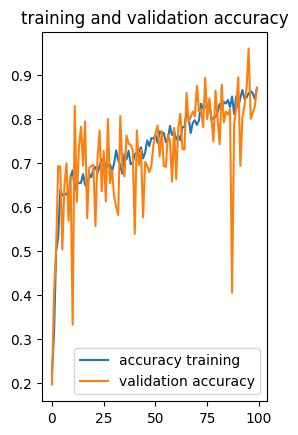

In [17]:
history.params
history.history['accuracy']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy'] 
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='accuracy training')
plt.plot(range(EPOCHS), val_acc, label='validation accuracy')
plt.legend(loc='lower right')
plt.title('training and validation accuracy')

Text(0.5, 1.0, 'training and validation loss')

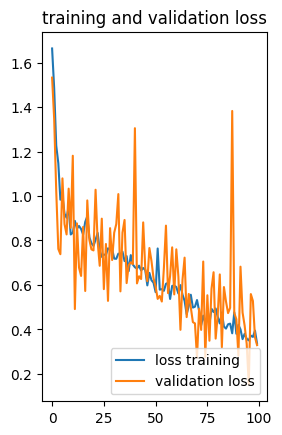

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss'] 
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label='loss training')
plt.plot(range(EPOCHS), val_loss, label='validation loss')
plt.legend(loc='lower right')
plt.title('training and validation loss')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


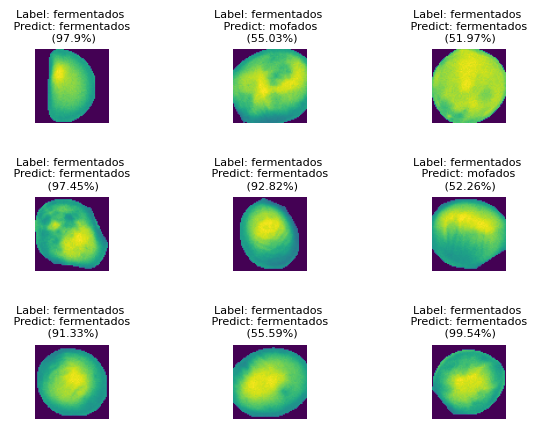

In [22]:
import tensorflow as tf


for images_batch, labels_batch in test_ds.take(1):    
    for i in range(9):
        plt.subplots_adjust(hspace=1, wspace=1)
        image = images_batch[i]
        label = labels_batch[i]
        
        im_to_show = image[...,0]
        batch_predict = model.predict(images_batch)

        best_predict = np.argmax(batch_predict[i])
        confidence = round(100 * (np.max(batch_predict[i])), 2)

        ax = plt.subplot(3,3, i+ 1)
        plt.imshow(im_to_show)
        plt.axis('off')
        plt.title(f'Label: {id_to_label[label.numpy()]} \n Predict: {id_to_label[best_predict]} \n ({confidence}%)', fontsize=8)
        
    

In [23]:
model.save(f"models/model_new{n_classes}_64.keras")